# TP 3 - MACHINE LEARNING 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# cargamos las features
feature_table = pd.read_csv('/home/martinagv/Documents/CienciaDatos/cdd/tp2/data/features.csv', index_col=0)
feature_table.head()

,delta_mean,theta_mean,alpha_mean,beta_mean,gamma_mean,delta_sd,theta_sd,alpha_sd,beta_sd,gamma_sd,...,gamma_mean_norm,delta_sd_norm,theta_sd_norm,alpha_sd_norm,beta_sd_norm,gamma_sd_norm,entropia1_mean,entropia1_sd,entropia2_mean,entropia2_sd
0,8.728339e-12,1.065061e-12,3.983039e-13,3.785312e-13,5.129398e-13,7.206072e-12,1.293176e-12,5.025695e-13,2.711422e-13,2.433669e-13,...,0.012358,0.140469,0.025208,0.009797,0.005285,0.004744,2.340374,0.446938,4.531177,0.606442
1,1.764836e-11,3.534803e-12,6.890699e-13,3.421829e-13,1.808768e-13,1.290129e-11,3.374498e-12,6.485887e-13,3.413046e-13,1.824950e-13,...,0.002535,0.141816,0.037094,0.007130,0.003752,0.002006,2.765994,0.510976,5.275764,0.658603
2,1.013907e-11,1.176905e-12,2.945534e-13,7.111791e-14,5.290585e-14,1.559310e-11,1.875917e-12,5.370765e-13,1.123730e-13,6.215384e-14,...,0.000730,0.332356,0.039984,0.011447,0.002395,0.001325,2.852978,0.400319,5.543353,0.520465
3,7.525308e-12,1.697106e-12,3.400314e-13,6.412720e-14,4.253743e-14,8.248725e-12,2.555380e-12,5.677615e-13,9.561613e-14,4.144363e-14,...,0.000950,0.217210,0.067290,0.014951,0.002518,0.001091,2.464267,0.500592,4.758656,0.657281
4,8.309858e-12,9.560017e-13,6.517436e-13,9.512539e-13,9.076269e-13,1.469131e-11,1.750826e-12,9.435580e-13,9.309765e-13,6.356544e-13,...,0.010231,0.231404,0.027577,0.014862,0.014664,0.010012,2.623431,0.605010,5.142181,0.808393


Nota: Los datos se encuentran normalizados tomando los valores de cada sujeto por separado.

## ANÁLISIS UNIVARIADO 

Para computar el área bajo la curva de cada feature, primero debemos construir un clasificador que prediga el tipo de paciente basándose en los valores de cada una de las features. Luego, el área bajo la curva nos dirá la performance del clasificador. Para el siguiente ejemplo utilizaremos un clasificador Logistic-Regression.    

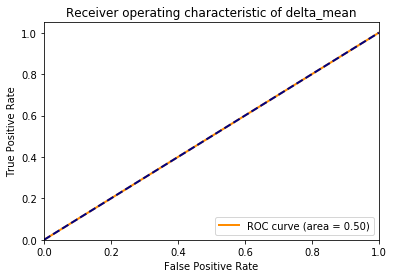

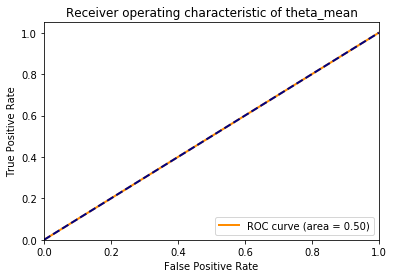

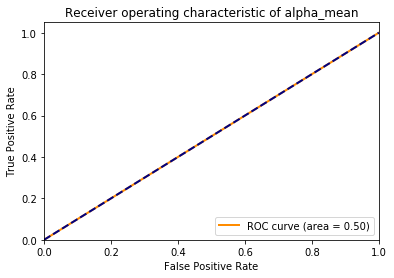

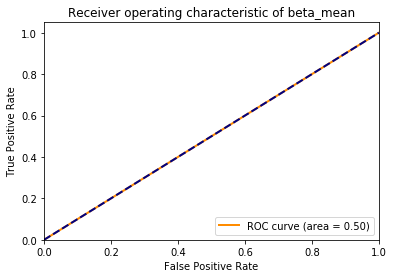

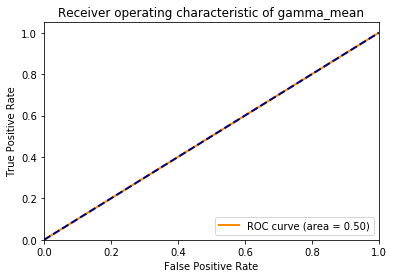

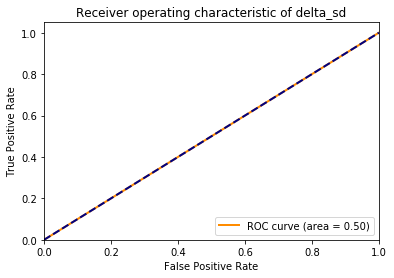

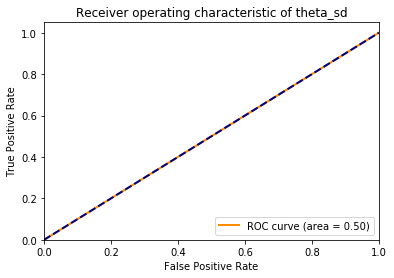

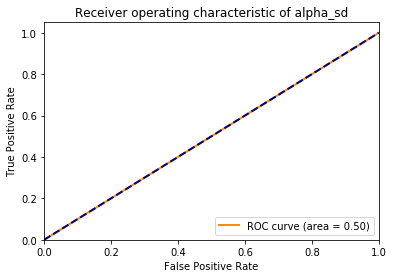

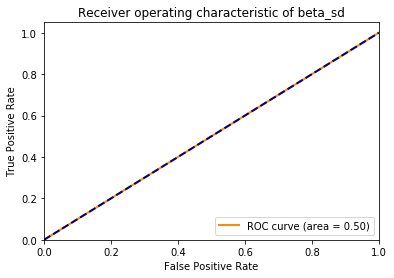

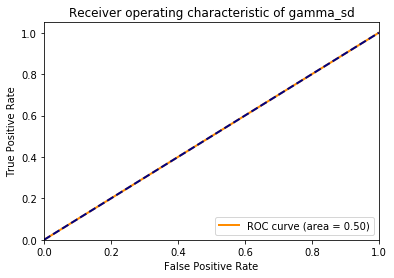

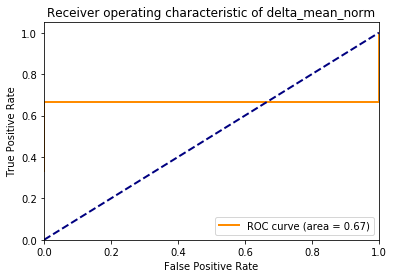

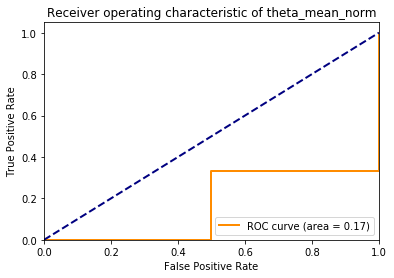

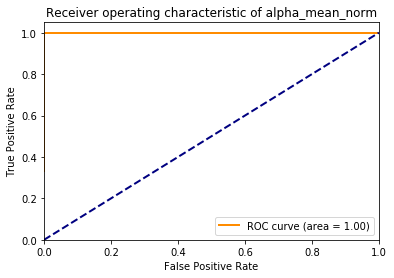

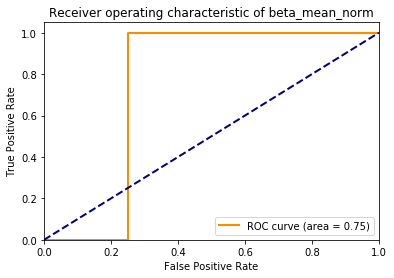

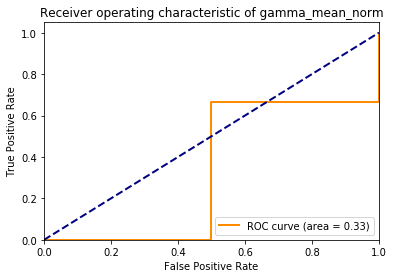

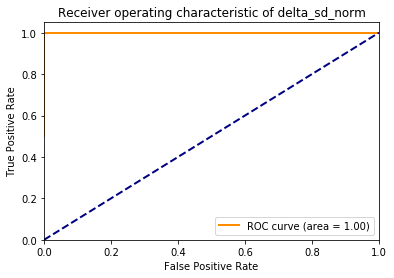

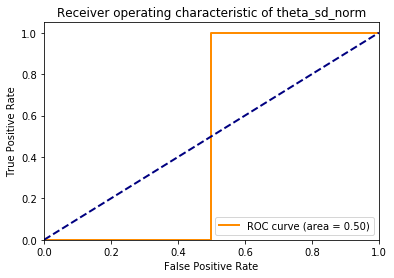

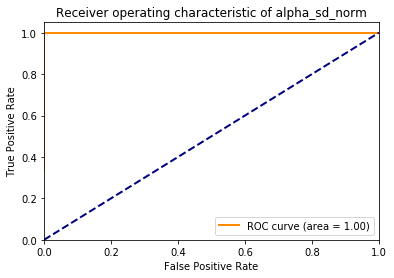

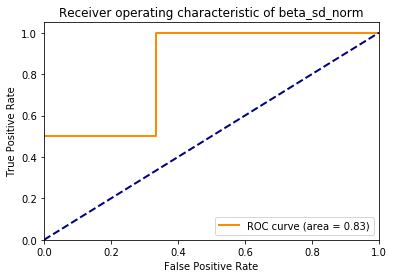

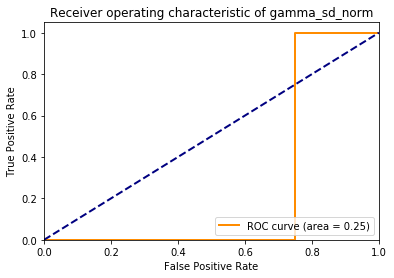

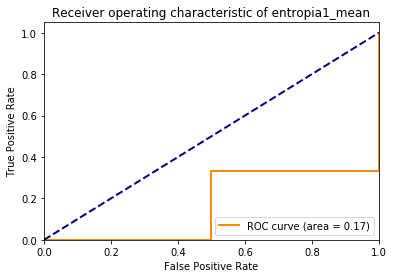

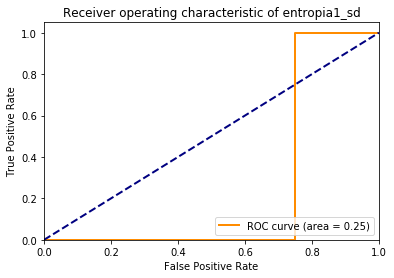

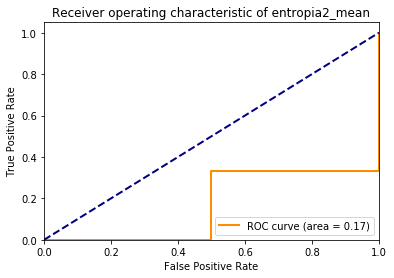

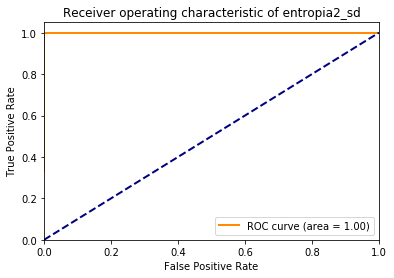

In [11]:
# definimos target
grupo = np.arange(20)
grupo[0:10]=0
grupo[10:20]=1

target = grupo

# definimos el clasificador que vamos a usar
clf = LogisticRegression()

# computamos la roc sobre cada feature usando logistic regression
columns = feature_table.columns
acc = []
aucs = []

for col in feature_table.columns:
    
    # definimos la feature que vamos a utilizar 
    data = feature_table[col]
    data = data.reshape(-1,1)

    # separamos los datos para entrenamiento y los datos para testeo
    X_train, X_test, y_train, y_test = train_test_split(data, target)

    # entrenamos el clasificador
    clf.fit(X_train, y_train)

    # predecimos los valores en el set de testeo
    y_predict = clf.predict(X_test) # predecimos valores categoriales
    y_probas = clf.predict_proba(X_test) # predecimos probabilidad de pertencer a una clase

    # computamos la medida de accuracy del clasificador
    accur = metrics.accuracy_score(y_test, y_predict)
    acc.append(accur)

    # computamos la curva roc
    fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1]) # label considered positive= pacientes P
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc) # guardamos las aucs de las distintas features

    # ploteamos la curva ROC para cada feature 
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of ' + col)
    plt.legend(loc="lower right")
    plt.show()

Repetimos el mismo proceso haciendo cross-validation:

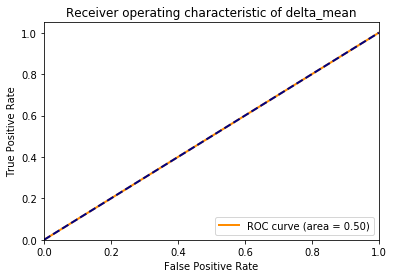

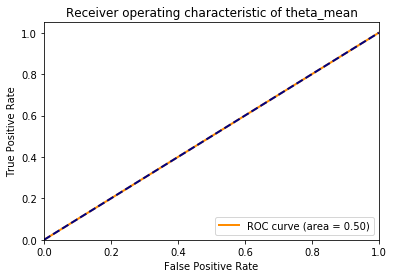

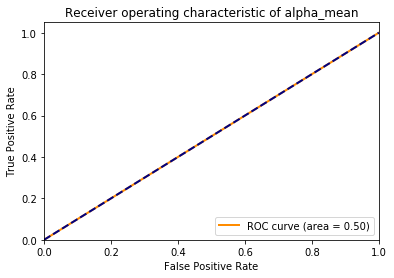

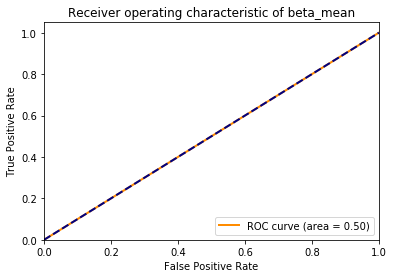

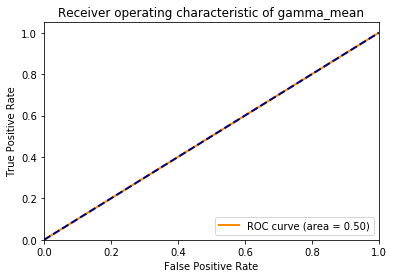

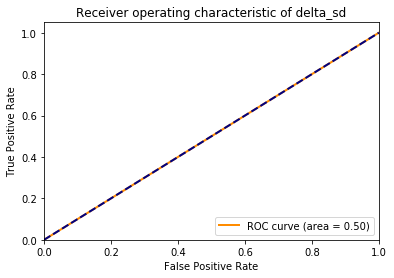

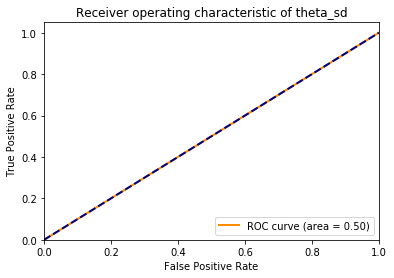

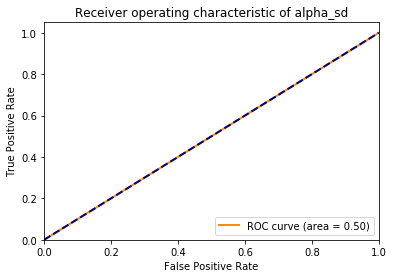

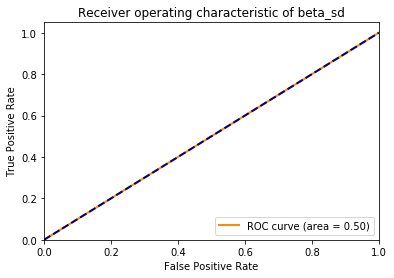

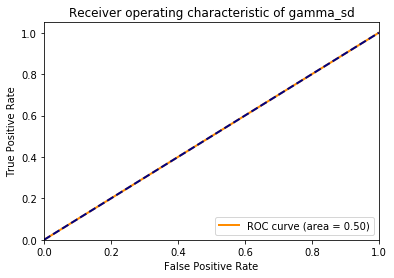

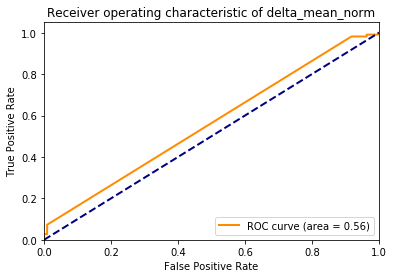

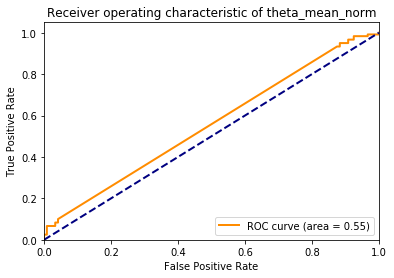

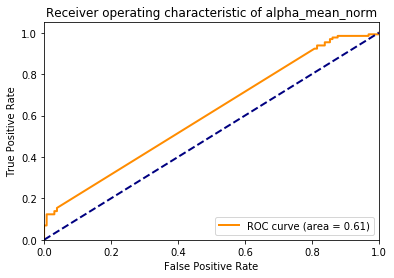

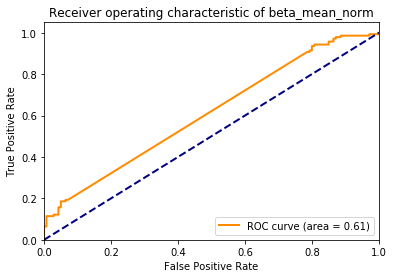

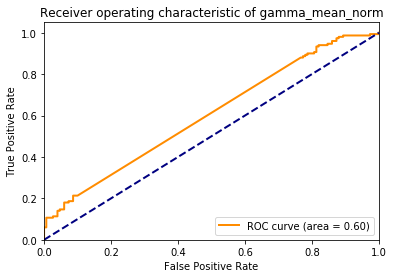

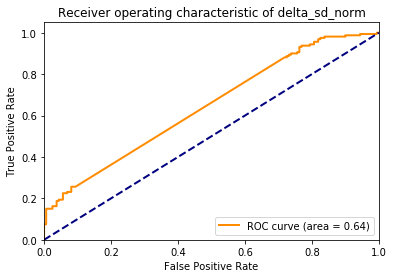

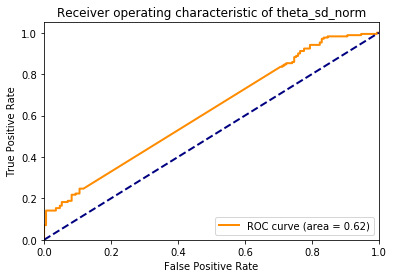

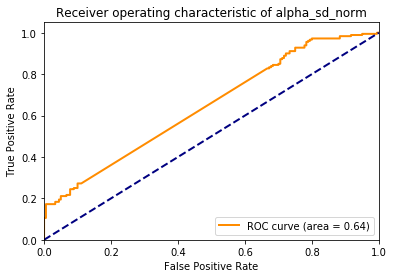

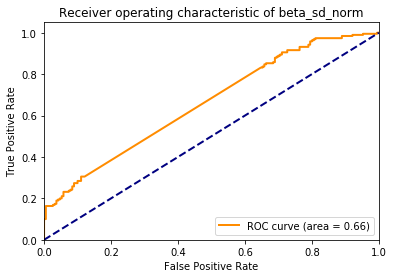

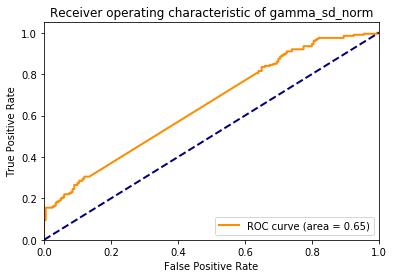

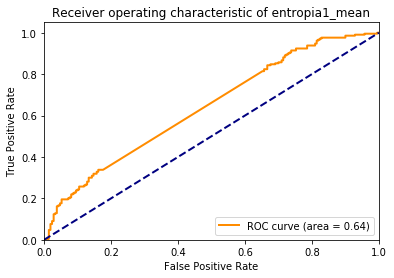

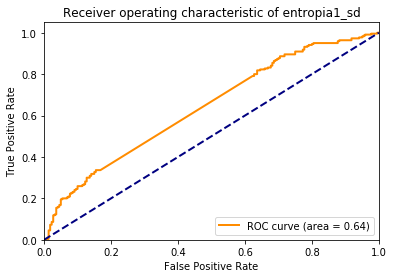

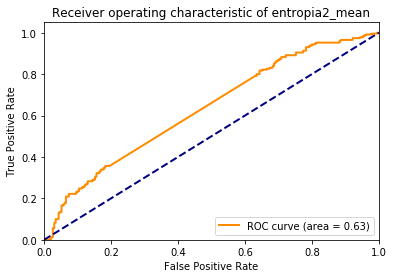

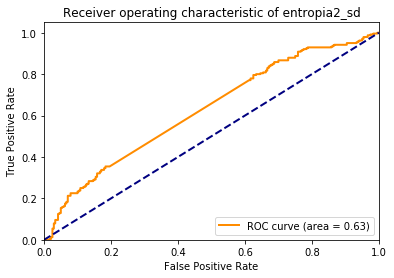

In [4]:
# definimos los parametros de cross-validation
n_folds = 5 
cv = StratifiedKFold(n_splits=n_folds)

# creamos las matrices donde guardamos los datos obtenidos en cada fold 
cv_target = np.array([])
cv_prediction = np.array([])
cv_probas = np.array([])
cv_df = np.array([])
acc2 = []
aucs2 = []

# computamos la roc para cada feature utilizando cross-validation 

for col in feature_table.columns:

    # definimos feature
    data = feature_table[col]
    data = data.reshape(-1,1)

    for train, test in cv.split(data, target): 
        X_train = data[train] # creamos el training set
        X_train = X_train.reshape(-1,1)
        X_test = data[test] # creamos el testing set
        y_train = target[train] # categoria real del training set 
        y_test = target[test] # categoria real del testing set 

        clf = clf.fit(X_train, y_train) # entrenamos clasificador
        preds = clf.predict(X_test) # predecimos valores categoriales
        probas = clf.predict_proba(X_test) # predecimos probabilidad de pertenecer a una clase

        # concatenamos los resultados de cada fold 
        cv_target = np.concatenate((cv_target, y_test), axis=0)
        cv_prediction = np.concatenate((cv_prediction, preds), axis=0)
        cv_probas = np.concatenate((cv_probas, probas[:, 1]), axis=0)

        # computamos la medida de accuracy del clasificador
        accur = metrics.accuracy_score(cv_target, cv_prediction)
        acc2.append(accur)

    # computamos la curva roc
    fpr, tpr, thresholds = roc_curve(cv_target, cv_probas) # la label considerada positiva es la de los pacientes P
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc) # guardamos las aucs de las distintas features

    # ploteamos la curva ROC
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of ' + col)
    plt.legend(loc="lower right")
    plt.show()

Excepto en los casos de las medias de potencias en cada banda, observamos que la performance de los clasificadores entrenados con cross-validation es más estable a través de las features. La variablidad disminuye ya que con cross-validation la predicción del clasificador no depende únicamente del training set que por azar le haya tocado, sino que es entrenado con varios conjuntos de training sets que van iterando a través del loop. 

## ANÁLISIS MULTIVARIADO  

Utilizaremos todos los features para entrenar un clasificador basado en Support Vector Machine, reportando el área bajo la curva del clasificador como medida de desempeño del mismo. 

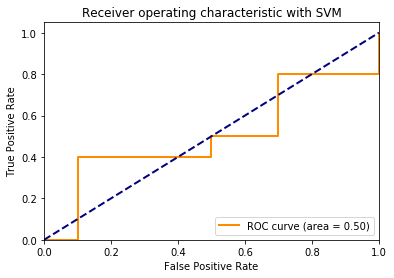

In [5]:
# definimos los features
data = feature_table.as_matrix()

# Definimos target
grupo = np.arange(20)
grupo[0:10]=0
grupo[10:20]=1

target = grupo

# definimos parametros de cross-validation
n_folds = 5  # Define number of folds
cv = StratifiedKFold(n_splits=n_folds)

# creamos las matrices donde guardamos los datos obtenidos en cada fold
cv_target = np.array([])
cv_prediction = np.array([])
cv_probas = np.array([])

clf = svm.SVC(probability=True, kernel='poly') # utilizamos un clasificador polinomial

# computamos la roc utilizando cross-validation
for train, test in cv.split(data, target):
    X_train = data[train] # creamos training set
    X_test = data[test] # creamos testing set
    y_train = target[train] # categoria real del training set
    y_test = target[test] # categoria real del testing set

    clf = clf.fit(X_train, y_train) # entrenamos clasificador
    preds = clf.predict(X_test) # predecimos valores categoriales
    probas = clf.predict_proba(X_test) # predecimos probabilidad de pertenecer a una clase

    # concatenate results
    cv_target = np.concatenate((cv_target, y_test), axis=0)
    cv_prediction = np.concatenate((cv_prediction, preds), axis=0)
    cv_probas = np.concatenate((cv_probas, probas[:, 1]), axis=0)

    # computamos la medida de accuracy del clasificador
    accur = metrics.accuracy_score(cv_target, cv_prediction)

# computamos la curva roc
fpr, tpr, thresholds = roc_curve(cv_target, cv_probas) # label considereda positiva = pacientes P
roc_auc = auc(fpr, tpr)

# ploteamos la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with SVM')
plt.legend(loc="lower right")
plt.show()


Repetimos el paso anterior agregando (mediante un pipeline) dos pasos previos que manipulan las features a utilizar por el clasificador. El primero (StandarScaler) estandariza las features, mientras que el segundo (SelectPercentile) selecciona un porcentaje de features predefinido (en el siguiente caso 10%) con los puntajes más altos. 

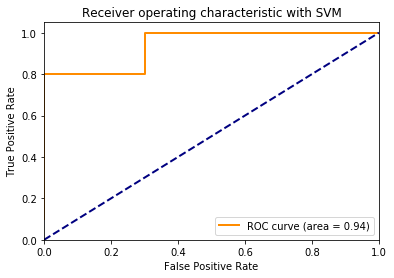

In [6]:
# Definimos los features
data = feature_table.as_matrix()

# Definimos target
grupo = np.arange(20)
grupo[0:10]=0
grupo[10:20]=1

target = grupo

# definimos parametros de cross-validation
n_folds = 5  # definimos numero de folds
cv = StratifiedKFold(n_splits=n_folds)

# creamos pipeline
estimators =[('StandardScaler', StandardScaler()),('SelectPercentile', SelectPercentile(percentile=10)), ('svm', svm.SVC(probability=True, kernel='poly'))]
clf = Pipeline(estimators)

# creamos las matrices donde guardamos los datos obtenidos en cada fold
cv_target = np.array([])
cv_prediction = np.array([])
cv_probas = np.array([])

# computamos la roc utilizando cross-validation
for train, test in cv.split(data, target):
    X_train = data[train] # creamos training set
    X_test = data[test] # creamos testing set
    y_train = target[train]  # categoria real del training set
    y_test = target[test]  # categoria real del testing set

    clf = clf.fit(X_train, y_train) # entrenamos clasificador
    preds = clf.predict(X_test) # predecimos valores categoriales
    probas = clf.predict_proba(X_test) # predecimos probabilidad de pertenecer a una clase

    # concatenamos resultados 
    cv_target = np.concatenate((cv_target, y_test), axis=0)
    cv_prediction = np.concatenate((cv_prediction, preds), axis=0)
    cv_probas = np.concatenate((cv_probas, probas[:, 1]), axis=0)

    # computamos la medida de accuracy del clasificador
    accur = metrics.accuracy_score(cv_target, cv_prediction)

# computamos la curva roc
fpr, tpr, thresholds = roc_curve(cv_target, cv_probas) # label considered positive= pacientes S
roc_auc = auc(fpr, tpr)

# ploteamos la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with SVM')
plt.legend(loc="lower right")
plt.show()

Repetimos el proceso anterior esta vez utilizando el 20% de las features con los puntajes más altos:

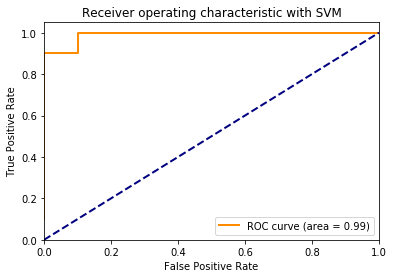

In [7]:
# Definimos los features
data = feature_table.as_matrix()

# Definimos target
grupo = np.arange(20)
grupo[0:10]=0
grupo[10:20]=1

target = grupo

# definimos parametros de cross-validation
n_folds = 5  # definimos numero de folds
cv = StratifiedKFold(n_splits=n_folds)

# creamos pipeline
estimators =[('StandardScaler', StandardScaler()),('SelectPercentile', SelectPercentile(percentile=20)), ('svm', svm.SVC(probability=True, kernel='poly'))]
clf = Pipeline(estimators)

# creamos las matrices donde guardamos los datos obtenidos en cada fold
cv_target = np.array([])
cv_prediction = np.array([])
cv_probas = np.array([])

# computamos la roc utilizando cross-validation
for train, test in cv.split(data, target):
    X_train = data[train] # creamos training set
    X_test = data[test] # creamos testing set
    y_train = target[train]  # categoria real del training set
    y_test = target[test]  # categoria real del testing set

    clf = clf.fit(X_train, y_train) # entrenamos clasificador
    preds = clf.predict(X_test) # predecimos valores categoriales
    probas = clf.predict_proba(X_test) # predecimos probabilidad de pertenecer a una clase

    # concatenamos resultados 
    cv_target = np.concatenate((cv_target, y_test), axis=0)
    cv_prediction = np.concatenate((cv_prediction, preds), axis=0)
    cv_probas = np.concatenate((cv_probas, probas[:, 1]), axis=0)

    # computamos la medida de accuracy del clasificador
    accur = metrics.accuracy_score(cv_target, cv_prediction)

# computamos la curva roc
fpr, tpr, thresholds = roc_curve(cv_target, cv_probas) # label considered positive= pacientes S
roc_auc = auc(fpr, tpr)

# ploteamos la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with SVM')
plt.legend(loc="lower right")
plt.show()

Repetimos el proceso anterior esta vez utilizando el 35% de las features con los puntajes más altos:

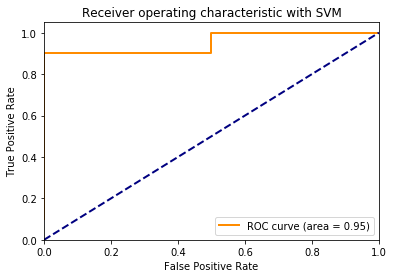

In [8]:
# Definimos los features
data = feature_table.as_matrix()

# Definimos target
grupo = np.arange(20)
grupo[0:10]=0
grupo[10:20]=1

target = grupo

# definimos parametros de cross-validation
n_folds = 5  # definimos numero de folds
cv = StratifiedKFold(n_splits=n_folds)

# creamos pipeline
estimators =[('StandardScaler', StandardScaler()),('SelectPercentile', SelectPercentile(percentile=35)), ('svm', svm.SVC(probability=True, kernel='poly'))]
clf = Pipeline(estimators)

# creamos las matrices donde guardamos los datos obtenidos en cada fold
cv_target = np.array([])
cv_prediction = np.array([])
cv_probas = np.array([])

# computamos la roc utilizando cross-validation
for train, test in cv.split(data, target):
    X_train = data[train] # creamos training set
    X_test = data[test] # creamos testing set
    y_train = target[train]  # categoria real del training set
    y_test = target[test]  # categoria real del testing set

    clf = clf.fit(X_train, y_train) # entrenamos clasificador
    preds = clf.predict(X_test) # predecimos valores categoriales
    probas = clf.predict_proba(X_test) # predecimos probabilidad de pertenecer a una clase

    # concatenamos resultados 
    cv_target = np.concatenate((cv_target, y_test), axis=0)
    cv_prediction = np.concatenate((cv_prediction, preds), axis=0)
    cv_probas = np.concatenate((cv_probas, probas[:, 1]), axis=0)

    # computamos la medida de accuracy del clasificador
    accur = metrics.accuracy_score(cv_target, cv_prediction)

# computamos la curva roc
fpr, tpr, thresholds = roc_curve(cv_target, cv_probas) # label considered positive= pacientes S
roc_auc = auc(fpr, tpr)

# ploteamos la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with SVM')
plt.legend(loc="lower right")
plt.show()

Observamos que el proceso de estandarización y selección de features mejoró la performance del clasificador. Sin embargo, encontramos poca diferencia entre seleccionar el 10%, 20% o 35% de las mejores features. 

Si la performance del clasificador fuera mayor utilizando el 35%, podríamos interpretar que al utilizar el 10% o el 20% de las mejores features estamos dejando fuera features que son relevantes para predecir la categoría. Pero también tendríamos que tener cuidado de no estar ante un problema de overfitting, especialmente dado el ratio de observaciones/features que tenemos. Al incrementar el número de features que estamos utilizando, incrementamos la posibilidad de estar ajustando mucho el modelo a nuestros datos de entrenamiento, y al mismo tiempo de reducir la generalización del clasificador ante nuevos datos. Sin embargo, esta posibilidad disminuye haciendo cross-validation. 

Idealmente, deberíamos de testear la performance del clasificador sobre un conjunto de datos que habríamos apartado antes de realizar el entrenamiento con cross-validation. Esto no fue posible ya que la consigna requería investigar cómo cambia la performance del clasificador según el número de features. Además, al tener un sample size bajo si particionaramos los datos tres veces terminaríamos por tener muy pocos casos en cada set de datos.